Data für 2023 loaded succsessfully.


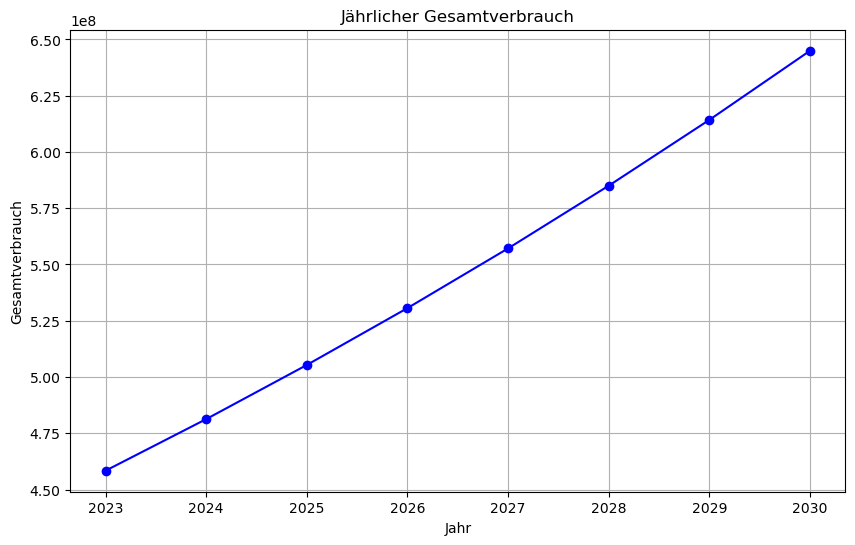

Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.
                    Datum  Wind Offshore  Wind Onshore  Photovoltaik  \
0     2024-01-01 00:00:00       704.7775     7503.0375          0.52   
1     2024-01-01 00:15:00       765.8050     7516.1625          0.26   
2     2024-01-01 00:30:00       841.5100     7667.3625          0.26   
3     2024-01-01 00:45:00       838.9350     7459.4625          0.26   
4     2024-01-01 01:00:00       809.0650     7688.1000          0.26   
...                   ...            ...           ...           ...   
35035 2024-12-31 22:45:00      1592.6375     7903.6125          0.52   
35036 2024-12-31 23:00:00      1560.9650     7911.7500          0.78   
35037 2024-12-31 23:15:00   

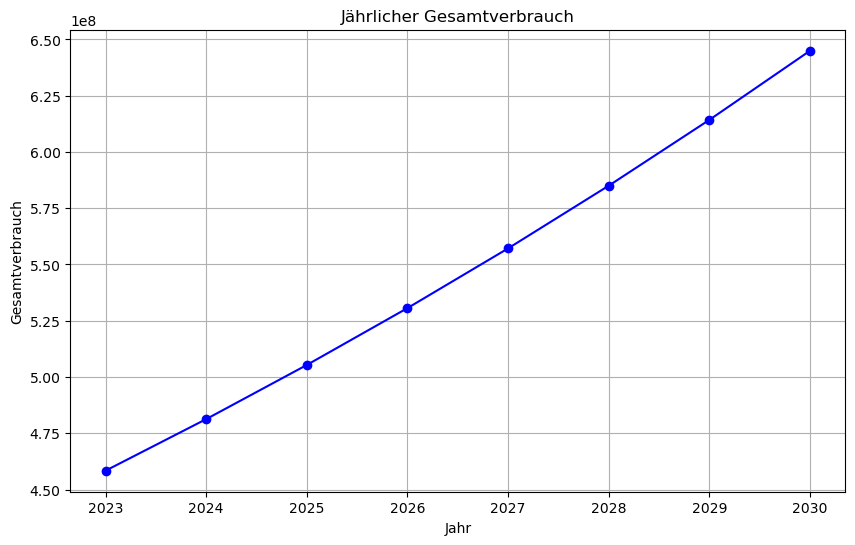

                    Datum  Gesamtverbrauch  Residuallast  Pumpspeicher  Year  \
0     2030-01-01 00:00:00     13610.882388       1842.50        482.00  2030   
1     2030-01-01 00:15:00     13499.017905       1691.50        469.25  2030   
2     2030-01-01 00:30:00     13454.694241       1442.50        546.25  2030   
3     2030-01-01 00:45:00     13392.078273       1598.50        525.50  2030   
4     2030-01-01 01:00:00     13273.530062       1325.50        192.75  2030   
...                   ...              ...           ...           ...   ...   
35035 2030-12-31 22:45:00     15169.597882       1706.75        373.50  2030   
35036 2030-12-31 23:00:00     15129.495520       1701.00        426.50  2030   
35037 2030-12-31 23:15:00     14923.003532       1610.25        476.75  2030   
35038 2030-12-31 23:30:00     14766.463610       1470.25        468.25  2030   
35039 2030-12-31 23:45:00     14476.249148       1338.00        540.75  2030   

      Week  
0       00  
1       00  


In [87]:
%run verbrauch.ipynb
%run eger-test-1.ipynb

In [88]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter

In [89]:
# Verbrauch pro Woche in ein Dataframe speichern

selectedYear = "2030"
selectedWeek = "30"

# daten nur für angegebene woche und jahr finden
week_filtered_data_consumption = consumption_extrapolation[
    (consumption_extrapolation['Year'] == selectedYear) & 
    (consumption_extrapolation['Week'] == selectedWeek)
]

# dataframe erstellen nur mit datum und gesamtverbrauch
week_consumption_df = week_filtered_data_consumption[['Datum', 'Gesamtverbrauch']]
week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])


print (week_consumption_df)

                    Datum  Gesamtverbrauch
20060 2030-07-29 00:00:00     14254.630832
20061 2030-07-29 00:15:00     14114.976115
20062 2030-07-29 00:30:00     13919.037381
20063 2030-07-29 00:45:00     13701.640366
20064 2030-07-29 01:00:00     13356.197212
...                   ...              ...
20727 2030-08-04 22:45:00     15372.923893
20728 2030-08-04 23:00:00     15112.610314
20729 2030-08-04 23:15:00     14866.719516
20730 2030-08-04 23:30:00     14523.387012
20731 2030-08-04 23:45:00     14396.747974

[672 rows x 2 columns]


/var/folders/0n/gbh_jry53x71gbfrplg1wthm0000gs/T/ipykernel_4086/281167979.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])


In [96]:
# Erzeugung PV, Onshore, Offshore-Wind in Dataframe speichern

#directory_yearly_generation
yearly_generation = pd.DataFrame.from_dict(directory_yearly_generation.get(int(selectedYear)))
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']

yearly_generation['EE_Gesamt'] = yearly_generation[required_columns].sum(axis=1)


week_filtered_data_production = yearly_generation[
    (yearly_generation['Week'] == selectedWeek)
]

week_production_df = week_filtered_data_production[['Datum', 'EE_Gesamt']]
week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])



print(week_production_df.head())


                    Datum    EE_Gesamt
20060 2030-07-29 00:00:00  1766.502046
20061 2030-07-29 00:15:00  1787.573648
20062 2030-07-29 00:30:00  1778.086432
20063 2030-07-29 00:45:00  1830.927921
20064 2030-07-29 01:00:00  1866.794314


/var/folders/0n/gbh_jry53x71gbfrplg1wthm0000gs/T/ipykernel_4086/451454840.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])


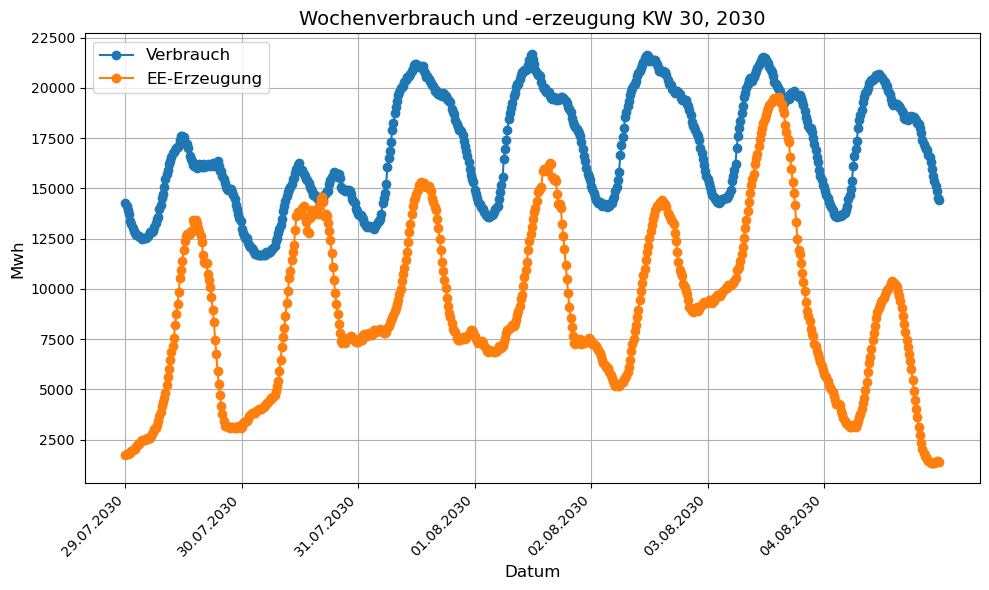

In [ ]:
def create_week_comparison(year, week, consumption_data, production_data):
    
    # Assuming your dataframes have columns 'Date' and 'Energy'
    plt.figure(figsize=(10, 6))

    # Plot consumption
    plt.plot(consumption_data['Datum'], consumption_data['Gesamtverbrauch'], label='Verbrauch', marker='o')

    # Plot production
    plt.plot(production_data['Datum'], production_data['EE_Gesamt'], label='EE-Erzeugung', marker='o')

    
     # Customize x-axis to show one tick per day
    unique_dates = consumption_data['Datum'].dt.normalize().unique()  # Get unique dates (one per day)
    plt.gca().set_xticks(unique_dates)  # Set ticks to these dates
    formatted_labels = [date.strftime('%d.%m.%Y') for date in unique_dates]  # Format labels
    plt.gca().set_xticklabels(formatted_labels, rotation=45, ha='right')  # Set labels and rotate


    # Adding labels and title
    plt.xlabel('Datum', fontsize=12)
    plt.ylabel('Mwh', fontsize=12)
    plt.title(f'Wochenverbrauch und -erzeugung KW {week}, {year}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


create_week_comparison(selectedYear, selectedWeek, week_consumption_df, week_production_df)